In [1]:
%matplotlib inline
import cv2 as cv
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import shutil
import random

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.applications import mobilenet_v2

Using TensorFlow backend.


In [3]:
#scaricare da github
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [4]:
os.makedirs('./ImageRec')

In [5]:
root_dir = './ImageRec'

In [6]:
def video_to_img(video_path, n_class):
    
    cam = cv.VideoCapture(video_path)
    os.makedirs('./ImageRec/' + n_class)
    currentframe = 0
    
    while(True): 
        
        ret,frame = cam.read() 
        if ret: 
            faces = face_detector.detectMultiScale(frame) 
            if len(faces) == 1:
                for (x,y,w,h) in faces:
                    face = frame[y:y+h,x:x+h,:]
                face=cv.resize(face, (224,224)) #lasciare o togliere?    
                name = './ImageRec/'+ n_class + '/frame' + str(currentframe) + '.jpg'
                print ('Creating...' + name) 
  
                cv.imwrite(name, face) 
  
            currentframe += 1
        else: 
            break
  
    cam.release() 
    cv.destroyAllWindows() 
    
    

Inserire un video con il volto da riconoscere e il numero della classe (numero della persona da riconoscere)

In [30]:
video_to_img('video.mp4', 'classe1')

In [29]:
video_to_img('video2.mp4', 'classe2')

In [10]:
def augment_brightness_camera_images(image):
    image1 = cv.cvtColor(image,cv.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv.cvtColor(image1,cv.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv.getAffineTransform(pts1,pts2)

    img = cv.warpAffine(img,Rot_M,(cols,rows))
    img = cv.warpAffine(img,Trans_M,(cols,rows))
    img = cv.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

In [11]:
def image_augmentation(path):
    for foto in os.listdir(path):
        img = mpimg.imread(os.path.join(path, foto))
        for i in range(3):
            imgg = transform_image(img,10,5,3,brightness=1)
            copia_foto = path + '/' + foto.rpartition('.jpg')[0] + 'copia' + str(i+1) + '.jpg'
            mpimg.imsave(copia_foto, imgg)
            print ('Creating...' + copia_foto ) 
    

In [31]:
for subdir in os.listdir(root_dir):
    image_augmentation(os.path.join(root_dir, subdir))

In [13]:
classes = [name for name in os.listdir(root_dir)]

In [14]:
classes

['classe1', 'classe2']

In [15]:
os.makedirs(root_dir +'/train')
os.makedirs(root_dir +'/test')

In [16]:
for cls in classes:
    
    os.makedirs(root_dir +'/train/' + cls)
    os.makedirs(root_dir +'/test/' + cls)
    src = root_dir + '/' + cls 

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(0.8))])

    
    
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test/' + cls)

Total images:  988
Training:  790
Testing:  198
Total images:  688
Training:  550
Testing:  138


In [17]:
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

In [18]:
train_preprocessing = kimage.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)

In [19]:
train_generator = train_preprocessing.flow_from_directory(
    directory='./ImageRec/train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=1
    )


Found 1340 images belonging to 2 classes.


In [20]:
test_preprocessing = kimage.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)

In [21]:
test_generator = test_preprocessing.flow_from_directory(
    directory='./ImageRec/test',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=1
    )

Found 336 images belonging to 2 classes.


In [22]:
for layer in mobilenet.layers:
    layer.trainable = False

In [23]:
x = mobilenet.output
x = Dense(1024, activation='relu')(x)
pred = Dense(2, activation='softmax')(x) 

net = Model(inputs=mobilenet.input, output=pred)

c:\users\marco\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [24]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(), #Adam()
            metrics=['accuracy'])

In [25]:
epochs = 10
#steps_per_epoch = 10

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [26]:
results = net.fit_generator(
    train_generator,
    epochs=epochs, #steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    callbacks = [early_stopping]
    )

Epoch 1/10
42/42 [==============================] - 124s 3s/step - loss: 0.7230 - accuracy: 0.8799 - val_loss: 0.4218 - val_accuracy: 0.8006
Epoch 2/10
42/42 [==============================] - 124s 3s/step - loss: 0.1785 - accuracy: 0.9425 - val_loss: 0.3305 - val_accuracy: 0.8095
Epoch 3/10
42/42 [==============================] - 126s 3s/step - loss: 0.0780 - accuracy: 0.9791 - val_loss: 0.0685 - val_accuracy: 0.8631
Epoch 4/10
42/42 [==============================] - 130s 3s/step - loss: 0.0304 - accuracy: 0.9918 - val_loss: 0.2427 - val_accuracy: 0.8423
Epoch 5/10
42/42 [==============================] - 150s 4s/step - loss: 0.0439 - accuracy: 0.9873 - val_loss: 1.6022 - val_accuracy: 0.6726
Epoch 6/10
42/42 [==============================] - 157s 4s/step - loss: 0.0088 - accuracy: 0.9970 - val_loss: 0.2737 - val_accuracy: 0.8393
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping


In [27]:
plt.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'accuracy':
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

        plt.legend()

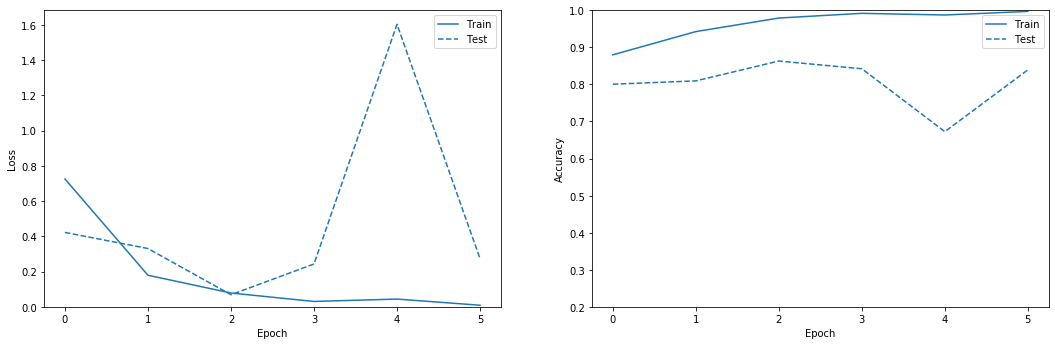

In [28]:
plot_metrics(results)